### Some notes: 
- i saw that some user, item tuples of the random test set are present in the training set, is this ok?
- is negative subsampling of 200 items ok? i switched to 60 to keep the ration
- is K=4 and K=20 ok for recall?
- grid search for gamma=1.5 gives better results on Stratified with gamma=3, then by looking for the number of partitions that minimizes gamma=3

In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import sys

# import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy import sparse, stats

In [2]:
import numpy as np
from openrec.tf1.legacy import ImplicitModelTrainer
from openrec.tf1.legacy.utils.evaluators import ImplicitEvalManager
from openrec.tf1.legacy.utils import ImplicitDataset
from openrec.tf1.legacy.recommenders import CML, BPR, PMF
from openrec.tf1.legacy.utils.evaluators import AUC
from openrec.tf1.legacy.utils.samplers import PairwiseSampler
from tqdm.notebook import tqdm
import numpy as np
import math
import pandas as pd
import os
import pickle


In [3]:
REPEAT_TRAINING = False

In [4]:
import sys
sys.path.append('../Lib')  # Adjusts path to include the Lib directory where utilities.py is located

In [5]:
from helper import *

In [6]:
# Set the seed for reproducibility
seed = 2384795
np.random.seed(seed=seed)

# Preparing folder for output data
output_name = f"./generated_data/"
if os.path.exists(output_name) == False:
    os.makedirs(output_name)

In [7]:
DATA_DIR = './original_files/'

## Loading Datasets

In [8]:
raw_data = pd.read_csv(os.path.join(DATA_DIR, 'train.ascii'), sep=" ", header=None, engine="python")
test_data = pd.read_csv(os.path.join(DATA_DIR, 'test.ascii'), sep=" ", header=None, engine="python")

In [9]:
tr_vd_data = pd.DataFrame({"userId": sparse.coo_matrix(raw_data).row,                            "songId": sparse.coo_matrix(raw_data).col,                           "rating": sparse.coo_matrix(raw_data).data})

In [10]:
test_data = pd.DataFrame({"userId": sparse.coo_matrix(test_data).row,                            "songId": sparse.coo_matrix(test_data).col,                           "rating": sparse.coo_matrix(test_data).data})

## Defining functions

In [11]:
def split_train_test_proportion(data):

    df_train = data

    # Create a test df
    df_test = pd.DataFrame(columns=data.columns)

    # Precompute, for each user, the list of songs with a relevant rating
    user_positive_ratings = data[data["rating"] == 1].groupby("user_id")["item_id"].apply(set)
    
    min_item, max_item = data['item_id'].min(), data['item_id'].max()

    # Initialize the range of indexes for the items
    items_ids = np.arange(min_item, max_item + 1)

    # Set the number of songs for each user
    SONGS_FOR_BIASED_TEST = 90

    users = set(data["user_id"].unique())

    # Extract the biased test set
    for user_id in users:

        # Get SONGS_FOR_BIASED_TEST items
        np.random.shuffle(items_ids)
        test_items = set(items_ids[-SONGS_FOR_BIASED_TEST:])

        # Get which are positive
        pos_ids = user_positive_ratings.get(user_id, set()) & test_items

        # Get which are negative but in test_items
        neg_ids = test_items - pos_ids

        # Set the positive ones to 0 in the training set (extract)
        df_train.loc[(df_train['item_id'].isin(pos_ids)) & (df_train['user_id'] == user_id), 'rating'] = 0

        # now add them in the test set
        # add to df_test the rows made of [user_id, pos_ids, 1] and [user_id, neg_ids, 0]
        for item_id in pos_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 1}, ignore_index=True)
        
        for item_id in neg_ids:
            df_test = df_test.append({'user_id': user_id, 'item_id': item_id, 'rating': 0}, ignore_index=True)

    # Convert back to the correct data types
    df_train['user_id'] = df_train['user_id'].astype(int)
    df_train['item_id'] = df_train['item_id'].astype(int)
    df_train['rating'] = df_train['rating'].astype(int)
    
    df_test['user_id'] = df_test['user_id'].astype(int)
    df_test['item_id'] = df_test['item_id'].astype(int)
    df_test['rating'] = df_test['rating'].astype(int)
    
    return df_train, df_test


In [12]:
def get_count(tp, id):
    playcount_groupbyid = tp[[id]].groupby(id, as_index=False)
    count = playcount_groupbyid.size()
    return count

## Make dataset implicit

In [13]:
tr_vd_data.head(10)

,userId,songId,rating
0,0,72,2
1,0,136,2
2,0,150,3
3,0,171,3
4,0,188,3
5,0,220,3
6,0,227,5
7,0,228,4
8,0,234,3
9,0,235,4


In [14]:
test_data.head(10)

,userId,songId,rating
0,0,12,4
1,0,17,3
2,0,74,4
3,0,78,2
4,0,92,2
5,0,104,4
6,0,127,4
7,0,128,3
8,0,133,3
9,0,145,2


In [15]:
# Suggested on the original yahoo's paper
POSITIVE_THRESHOLD = 4

# Add column to the DataFrame
tr_vd_data['ImplicitRating'] = np.where(tr_vd_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)
test_data['ImplicitRating'] = np.where(test_data['rating'] >= POSITIVE_THRESHOLD, 1, 0)

In [16]:
tr_vd_data.head(10)

,userId,songId,rating,ImplicitRating
0,0,72,2,0
1,0,136,2,0
2,0,150,3,0
3,0,171,3,0
4,0,188,3,0
5,0,220,3,0
6,0,227,5,1
7,0,228,4,1
8,0,234,3,0
9,0,235,4,1


In [17]:
tr_vd_data = tr_vd_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')

In [18]:
tr_vd_data.head(10)

,userId,songId,rating
0,0,72,0
1,0,136,0
2,0,150,0
3,0,171,0
4,0,188,0
5,0,220,0
6,0,227,1
7,0,228,1
8,0,234,0
9,0,235,1


In [19]:
test_data.head(10)

,userId,songId,rating,ImplicitRating
0,0,12,4,1
1,0,17,3,0
2,0,74,4,1
3,0,78,2,0
4,0,92,2,0
5,0,104,4,1
6,0,127,4,1
7,0,128,3,0
8,0,133,3,0
9,0,145,2,0


In [20]:
test_data = test_data.drop(['rating'],axis=1).rename({"ImplicitRating":"rating"}, axis='columns')

In [21]:
test_data.head(10)

,userId,songId,rating
0,0,12,1
1,0,17,0
2,0,74,1
3,0,78,0
4,0,92,0
5,0,104,1
6,0,127,1
7,0,128,0
8,0,133,0
9,0,145,0


In [22]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  4640 non-null   int32
 1   songId  4640 non-null   int32
 2   rating  4640 non-null   int64
dtypes: int32(2), int64(1)
memory usage: 72.6 KB


## Some stats

In [23]:
tr_vd_data.head(), tr_vd_data.shape

(   userId  songId  rating
 0       0      72       0
 1       0     136       0
 2       0     150       0
 3       0     171       0
 4       0     188       0,
 (6960, 3))

In [24]:
test_data.head(), test_data.shape

(   userId  songId  rating
 0       0      12       1
 1       0      17       0
 2       0      74       1
 3       0      78       0
 4       0      92       0,
 (4640, 3))

In [25]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4640 entries, 0 to 4639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   userId  4640 non-null   int32
 1   songId  4640 non-null   int32
 2   rating  4640 non-null   int64
dtypes: int32(2), int64(1)
memory usage: 72.6 KB


In [26]:
user_activity = get_count(tr_vd_data, 'userId')
item_popularity = get_count(tr_vd_data, 'songId')

In [27]:
unique_uid = user_activity.index
unique_sid = item_popularity.index

In [28]:
n_users = len(unique_uid)
n_items = len(unique_sid)

In [29]:
n_users, n_items

(290, 300)

## Removing eventual songs and users from the test set not present in the training set

In [30]:
song2id = dict((sid, i) for (i, sid) in enumerate(unique_sid))
user2id = dict((uid, i) for (i, uid) in enumerate(unique_uid))

In [31]:
# for the test set, only keep the users/items from the training set

test_data = test_data.loc[test_data['userId'].isin(unique_uid)]
test_data = test_data.loc[test_data['songId'].isin(unique_sid)]

## Turn userId and songId to 0-based index

In [32]:
def numerize(tp):
    uid = list(map(lambda x: user2id[x], tp['userId']))
    sid = list(map(lambda x: song2id[x], tp['songId']))
    tp.loc[:, 'user_id'] = uid
    tp.loc[:, 'item_id'] = sid
    return tp[['user_id', 'item_id', 'rating']]

In [33]:
tr_vd_data = numerize(tr_vd_data)
test_data = numerize(test_data)

## Split

In [34]:
train_data, obs_test_data = split_train_test_proportion(tr_vd_data)

In [35]:
print("There are total of %d unique users in the training set and %d unique users in the entire dataset" % (len(pd.unique(train_data['user_id'])), len(unique_uid)))

There are total of 290 unique users in the training set and 290 unique users in the entire dataset


In [36]:
print("There are total of %d unique items in the training set and %d unique items in the entire dataset" % (len(pd.unique(train_data['item_id'])), len(unique_sid)))

There are total of 300 unique items in the training set and 300 unique items in the entire dataset


In [37]:
def move_to_fill(part_data_1, part_data_2, unique_id, key):
    # move the data from part_data_2 to part_data_1 so that part_data_1 has the same number of unique "key" as unique_id
    part_id = set(pd.unique(part_data_1[key]))
    
    left_id = list()
    for i, _id in enumerate(unique_id):
        if _id not in part_id:
            left_id.append(_id)
            
    move_idx = part_data_2[key].isin(left_id)
    part_data_1 = part_data_1.append(part_data_2[move_idx])
    part_data_2 = part_data_2[~move_idx]
    return part_data_1, part_data_2

The move_to_fill function is used to ensure that train_data ends up with a complete set of unique IDs as specified by unique_id, by "moving" the necessary rows from another dataset (part_data_2 like vad_data or obs_test_data) and updating both DataFrames accordingly.

In [38]:
#train_data, vad_data = move_to_fill(train_data, vad_data, np.arange(n_items), 'item_id')
train_data, obs_test_data = move_to_fill(train_data, obs_test_data, np.arange(n_items), 'item_id')

In [39]:
print("There are total of %d unique items in the training set and %d unique items in the entire dataset" % (len(pd.unique(train_data['item_id'])), len(unique_sid)))

There are total of 300 unique items in the training set and 300 unique items in the entire dataset


## Store datasets in csv files

In [40]:
train_data.to_csv(os.path.join(output_name, 'train.csv'), index=False)
#vad_data.to_csv(os.path.join(output_name, 'validation.csv'), index=False)
tr_vd_data.to_csv(os.path.join(output_name, 'train_full.csv'), index=False)

In [41]:
obs_test_data.to_csv(os.path.join(output_name, 'obs_test_full.csv'), index=False)
test_data.to_csv(os.path.join(output_name, 'test_full.csv'), index=False)

now *obs_test_data* is our biased testset extracted by the original dataset, while *test_data* is our unbiased test set 

In [42]:
obs_test_data

,user_id,item_id,rating
0,0,298,1
1,0,251,1
2,0,228,1
3,0,236,1
4,0,257,0
...,...,...,...
26095,289,237,0
26096,289,239,0
26097,289,244,0
26098,289,249,0


## Build files for creating dataset for the openrec library

# Biased

In [43]:
# Init empty
pos_test_set = []
neg_test_set = []

In [44]:
# Create masks for positive and negative ratings
pos_mask = obs_test_data['rating'] == 1
neg_mask = obs_test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = obs_test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = obs_test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# pos_test_set and neg_test_set now contain the lists of [user_id, item_id] for positive and negative ratings, respectively.
# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

In [45]:
pos_test_set

array([[  0, 298],
       [  0, 251],
       [  0, 228],
       ...,
       [287, 138],
       [287, 120],
       [288,  36]])

In [46]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "biased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "biased-test_arr_neg.npy", structured_data_neg_test_set)

# Unbiased

In [47]:
# Init empty
pos_test_set = []
neg_test_set = []

In [48]:
# Create masks for positive and negative ratings
pos_mask = test_data['rating'] == 1
neg_mask = test_data['rating'] != 1

# Extract the user_id and item_id pairs for positive and negative ratings
pos_test_set = test_data.loc[pos_mask, ['user_id', 'item_id']].values.tolist()
neg_test_set = test_data.loc[neg_mask, ['user_id', 'item_id']].values.tolist()

# pos_test_set and neg_test_set now contain the lists of [user_id, item_id] for positive and negative ratings, respectively.
# Get np arrays
pos_test_set = np.array(pos_test_set)
neg_test_set = np.array(neg_test_set)

In [49]:
# Get the dataframe
pos_test_set_df = pd.DataFrame(pos_test_set)
neg_test_set_df = pd.DataFrame(neg_test_set)

# Get couples user-item
pos_test_set_df.columns = ["user_id","item_id"]
neg_test_set_df.columns = ["user_id","item_id"]

# Turn into records
structured_data_pos_test_set = pos_test_set_df.to_records(index=False)
structured_data_neg_test_set = neg_test_set_df.to_records(index=False)

# Save
np.save(output_name + "unbiased-test_arr_pos.npy", structured_data_pos_test_set)
np.save(output_name + "unbiased-test_arr_neg.npy", structured_data_neg_test_set)

# Trainset

In [50]:
positive_trainset = train_data[train_data['rating'] != 0]
positive_trainset = positive_trainset.drop(columns=['rating'])

# Convert the DataFrame to a structured array
positive_trainset = positive_trainset.to_records(index=False) 

# Save
np.save(output_name + "training_arr.npy", positive_trainset)

In [51]:
output_name

'./generated_data/'

In [52]:
train_data["user_id"].unique().size, test_data["user_id"].unique().size, obs_test_data["user_id"].unique().size

(290, 290, 290)

In [53]:
train_data["user_id"].unique().max(), test_data["user_id"].unique().max(), obs_test_data["user_id"].unique().max()

(289, 289, 289)

In [54]:
train_data["item_id"].unique().size, test_data["item_id"].unique().size, obs_test_data["item_id"].unique().size

(300, 300, 300)

In [55]:
train_data["item_id"].unique().max(), test_data["item_id"].unique().max(), obs_test_data["item_id"].unique().max()

(299, 299, 299)

In [56]:
old_pos = np.load(output_name + "biased-test_arr_pos_old.npy")
old_neg = np.load(output_name + "biased-test_arr_neg_old.npy")

old_pos_un = np.load(output_name + "unbiased-test_arr_pos_old.npy")
old_neg_un = np.load(output_name + "unbiased-test_arr_neg_old.npy")

old_train = np.load(output_name + "training_arr_old.npy")

new_pos = np.load(output_name + "biased-test_arr_pos.npy")
new_neg = np.load(output_name + "biased-test_arr_neg.npy")

In [57]:
for i in range(old_neg.size):
    if old_neg[i] != new_neg[i]:
        print(i)

In [58]:
for i in range(old_pos.size):
    if old_pos[i] != new_pos[i]:
        print(i)

In [59]:
for i in range(old_train.size):
    if old_train[i] != positive_trainset[i]:
        print(i)

In [60]:
for i in range(old_pos_un.size):
    if old_pos_un[i] != structured_data_pos_test_set[i]:
        print(i)

In [61]:
for i in range(old_neg_un.size):
    if old_neg_un[i] != structured_data_neg_test_set[i]:
        print(i)

# **MODEL CHOICE**

In [62]:
# Here I won't comment anything, we are just using the code provided by the authors of the paper

raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy" )
raw_data['max_user'] = 290
raw_data['max_item'] = 300
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')

MODEL_CLASS = CML
MODEL_PREFIX = "cml"
DATASET_NAME = "coat"
OUTPUT_FOLDER = output_name
OUTPUT_PATH = OUTPUT_FOLDER + MODEL_PREFIX + "-" + DATASET_NAME + "/"
OUTPUT_PREFIX = str(OUTPUT_PATH) + str(MODEL_PREFIX) + "-" + str(DATASET_NAME)


if os.path.exists(OUTPUT_PATH) == False:
    os.makedirs(OUTPUT_PATH)


In [63]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()
tf.set_random_seed(seed)

In [64]:
if REPEAT_TRAINING:

    # Define the model
    model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
    sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
    model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
    auc_evaluator = AUC()

    # Train the model
    model_trainer.train(num_itr=10001, display_itr=display_itr)

    # Save in the output folder
    model.save(OUTPUT_PATH,None)

    # Delete the model from the memory
    del model

# **EVALUATION**

In [65]:
GAMMAS = [1.5,2,2.5,3]

In [66]:
# Load data
raw_data = dict()
raw_data['train_data'] = np.load(output_name + "training_arr.npy")
raw_data['test_data_pos_biased'] = np.load(output_name + "biased-test_arr_pos.npy")
raw_data['test_data_neg_biased'] = np.load(output_name + "biased-test_arr_neg.npy")
raw_data['test_data_pos_unbiased'] = np.load(output_name + "unbiased-test_arr_pos.npy")
raw_data['test_data_neg_unbiased'] = np.load(output_name + "unbiased-test_arr_neg.npy")
raw_data['max_user'] = 290
raw_data['max_item'] = 300
batch_size = 8000
test_batch_size = 1000
display_itr = 1000

# Load data
train_dataset = ImplicitDataset(raw_data['train_data'], raw_data['max_user'], raw_data['max_item'], name='Train')
test_dataset_pos_biased = ImplicitDataset(raw_data['test_data_pos_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_biased = ImplicitDataset(raw_data['test_data_neg_biased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_pos_unbiased = ImplicitDataset(raw_data['test_data_pos_unbiased'], raw_data['max_user'], raw_data['max_item'])
test_dataset_neg_unbiased = ImplicitDataset(raw_data['test_data_neg_unbiased'], raw_data['max_user'], raw_data['max_item'])

In [67]:
# Prevent tensorflow from using cached embeddings
import tensorflow as tf
tf.compat.v1.reset_default_graph()

# Define the model
model = MODEL_CLASS(batch_size=batch_size, max_user=train_dataset.max_user(), max_item=train_dataset.max_item(), dim_embed=50, l2_reg=0.001, opt='Adam', sess_config=None)
sampler = PairwiseSampler(batch_size=batch_size, dataset=train_dataset, num_process=4)
model_trainer = ImplicitModelTrainer(batch_size=batch_size, test_batch_size=test_batch_size, train_dataset=train_dataset, model=model, sampler=sampler, eval_save_prefix=OUTPUT_PATH + DATASET_NAME, item_serving_size=500)
auc_evaluator = AUC()

# Load model
model.load(OUTPUT_PATH)

# Set parameters
model_trainer._eval_manager = ImplicitEvalManager(evaluators=[auc_evaluator])
model_trainer._num_negatives = 60 # in yahoo they were 200 on 1000 items, so let's keep a 1/5 ratio on 300 items
model_trainer._exclude_positives([train_dataset, test_dataset_pos_biased, test_dataset_neg_biased])
model_trainer._sample_negatives(seed=10)


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
keep_dims is deprecated, use keepdims instead

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where






2024-08-20 16:54:40.176828: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 AVX512F FMA
2024-08-20 16:54:40.180678: I tensorflow/core/platform/profile_utils/cpu_utils.cc:94] CPU Frequency: 4192055000 Hz
2024-08-20 16:54:40.181513: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x56320fe93280 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2024-08-20 16:54:40.181536: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


INFO:tensorflow:Restoring parameters from ./generated_data/cml-coat/
[Subsampling negative items]


## Biased Evaluation

In [68]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-biased"
model_trainer._evaluate_partial(test_dataset_pos_biased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-biased"
model_trainer._evaluate_partial(test_dataset_neg_biased)

100%|██████████| 290/290 [00:00<00:00, 763.01it/s]


{'AUC': [0.5174418604651163,
  0.5998127340823971,
  0.5015151515151515,
  0.48787878787878786,
  0.49475655430711607,
  0.4521072796934867,
  0.41231060606060604,
  0.47977528089887644,
  0.4724137931034482,
  0.5959770114942529,
  0.4951851851851851,
  0.48023255813953486,
  0.5259259259259259,
  0.552059925093633,
  0.57,
  0.5661048689138578,
  0.5016666666666667,
  0.48295880149812737,
  0.46098484848484844,
  0.4962546816479401,
  0.4848837209302325,
  0.5494186046511628,
  0.4256862745098039,
  0.46460674157303367,
  0.49940476190476185,
  0.44906367041198497,
  0.5128352490421455,
  0.47528089887640446,
  0.44063670411985023,
  0.5376404494382022,
  0.5084313725490195,
  0.5400749063670411,
  0.4509469696969697,
  0.5266666666666666,
  0.5074906367041199,
  0.5106060606060606,
  0.537689393939394,
  0.5735185185185184,
  0.5591954022988505,
  0.45705882352941185,
  0.5119850187265917,
  0.5535984848484848,
  0.5269379844961242,
  0.48089887640449436,
  0.5728464419475655,
  0.5

## Unbiased Evaluation

In [69]:
model_trainer._eval_save_prefix = OUTPUT_PREFIX + "-test-pos-unbiased"
model_trainer._evaluate_partial(test_dataset_pos_unbiased)

model_trainer._eval_save_prefix = OUTPUT_PREFIX +  "-test-neg-unbiased"
model_trainer._evaluate_partial(test_dataset_neg_unbiased)

100%|██████████| 290/290 [00:00<00:00, 2371.33it/s]


{'AUC': [0.5216666666666666,
  0.5928571428571429,
  0.5217948717948718,
  0.5192307692307692,
  0.5166666666666667,
  0.5988095238095238,
  0.4777777777777777,
  0.5770833333333334,
  0.4833333333333334,
  0.5076923076923076,
  0.3679487179487179,
  0.37166666666666665,
  0.5047619047619047,
  0.5888888888888889,
  0.47888888888888886,
  0.7273809523809522,
  0.51875,
  0.419047619047619,
  0.4833333333333334,
  0.5588888888888889,
  0.4477777777777777,
  0.5694444444444444,
  0.3270833333333334,
  0.5072916666666667,
  0.5015151515151515,
  0.4761904761904762,
  0.5888888888888889,
  0.45555555555555566,
  0.4404761904761905,
  0.5202380952380953,
  0.4196969696969697,
  0.4642857142857143,
  0.40888888888888886,
  0.46969696969696967,
  0.5535714285714286,
  0.3037037037037037,
  0.4708333333333334,
  0.44166666666666665,
  0.4599999999999999,
  0.32999999999999996,
  0.40625,
  0.4871794871794872,
  0.6266666666666666,
  0.6244444444444445,
  0.5866666666666667,
  0.534444444444444

## Calculate Propensities

In [70]:
propensities = calculate_propensities(290,300, output_name+"training_arr.npy")

In [71]:
propensities

{1.5: array([[1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823],
        [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823],
        [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823],
        ...,
        [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823],
        [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823],
        [1.        , 0.        , 0.09453009, ..., 0.19708824, 0.04991823,
         0.04991823]]),
 2: array([[1.        , 0.        , 0.05897719, ..., 0.14242717, 0.02741012,
         0.02741012],
        [1.        , 0.        , 0.05897719, ..., 0.14242717, 0.02741012,
         0.02741012],
        [1.        , 0.        , 0.05897719, ..., 0.14242717, 0.02741012,
         0.02741012],
        ...,
        [1.        , 0.        , 0.05897719, ..., 0.14242717, 0.02741012,
         0.02741012],
    

## Calculate Metrics

Compute AOA and unbiased evaluator metrics with biased testset.

In [72]:
biased_results = dict()

biased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", K=20)

for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    biased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=20)

Compute AOA and unbiased evaluator metrics with unbiased testset.

In [73]:
unbiased_results = dict()

# unbiased_results["STRATIFIED_15"] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", gamma=1.5, K=4, partition=100)
unbiased_results["AOA"] = aoa(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", K=4)
for gamma in GAMMAS:
    key = "UB_" + str(gamma).replace(".","")
    unbiased_results[key] = eq(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=4)

Get partitions.

In [74]:
# Get number of items
num_items = 300

# Get the n_p partitions
n_p = 300
nums = np.arange(1, num_items+1)
partitions = np.random.choice(nums, n_p, replace=False)

# Visualize
partitions

array([118, 198, 186,  96, 232, 124, 241, 253, 235,  68, 135,  63, 179,
       236, 243, 128,  87, 225, 162, 239,  97,  83,  23, 256, 192, 209,
       150,   1, 153, 216, 294, 290, 143,  45, 287,  12, 114, 102, 180,
         5,  90, 140, 234, 184,  70, 175,   2, 246, 211, 100, 300,  36,
        85, 240, 108, 213,  39,  69,  66, 201, 101, 152, 210,  11, 110,
       220,  72,  43,  79, 200,  13, 270, 295,  48,  91,  92, 166,  31,
       167, 119, 190,  86, 194, 127, 106, 227,  61, 269, 161,  22, 204,
        20, 264, 296, 172, 156, 202, 218, 147,  82,  50, 163, 158, 196,
       176, 242, 120, 117, 168, 267, 151,  56, 206, 197, 277, 231, 178,
        67, 284, 297, 224, 229,  99, 221, 142,   4,  44, 136, 169, 165,
       203,  64,  15, 268, 164, 195, 145, 272, 257, 115,  51,   6, 134,
        88, 207,  78, 271, 278, 181,  80,  93,  28, 208,  10, 137, 177,
        54, 286, 121,  42, 233, 237,  84, 248,  19, 149, 171, 191,  89,
       199, 238, 293, 188,  53, 266, 273, 173, 155,   3, 130,  7

Compute the partition which minimizes the sum of AUC and Recall

In [90]:
# Compute biased and unbiased results with stratified for each partition
# and store biased and unbiased results such that the sum of AUC and Recall is minimized

# Value of gamma to use for minimization
gamma = 1.5
optimized_gamma = gamma

# To print :)
key = "STRATIFIED_" + str(gamma).replace(".","")
print(key)

unbiased_results[key] = {}
biased_results[key] = {}
best_partition = np.random.choice(nums, 1)[0]
best_score = float('inf')

history = np.full(300, np.inf)  # Adjusted to match the size of nums

for p in tqdm(partitions):
    # Fetch stratified results; these functions need to be defined or replaced with actual logic
    temp_unbiased = stratified(OUTPUT_PREFIX + "-test-pos-unbiased_evaluate_partial.pickle",
                               OUTPUT_PREFIX + "-test-neg-unbiased_evaluate_partial.pickle",
                               output_name + "training_arr.npy", propensities[gamma], K=4, partition=p)
    temp_biased = stratified(OUTPUT_PREFIX + "-test-pos-biased_evaluate_partial.pickle",
                             OUTPUT_PREFIX + "-test-neg-biased_evaluate_partial.pickle",
                             output_name + "training_arr.npy", propensities[gamma], K=20, partition=p)
    

    # Calculate combined score
    combined_score = temp_unbiased['bias'] + temp_unbiased['concentration'] + \
                     temp_biased['bias'] + temp_biased['concentration']

    history[p-1] = combined_score  # Store the combined score

    # Update the best_partition and best_score if the current partition's score is lower
    if combined_score < best_score:
        best_score = combined_score
        best_partition = p

print(f"Best partition: {best_partition} with combined score: {best_score}")
print(f"Minimum score from history: {np.min(history)}")


STRATIFIED_15


  0%|          | 0/300 [00:00<?, ?it/s]

Best partition: 6 with combined score: 470378.78110936837
Minimum score from history: 470378.78110936837


In [76]:
# Additional outputs for verification
print("Detailed scores from history:", history)

Detailed scores from history: [529519.48233917 499238.91688669 487356.19822567 483802.33112075
 472363.60218076 470378.78110937 473440.03103509 478848.65373798
 477571.72335666 489403.45431129 488412.00986435 488340.3146493
 509779.84040569 509342.39678315 509219.17469782 508835.86505503
 578489.54725109 578599.68503631 576229.70919337 576152.56308168
 575830.40016507 575553.9280211  575442.97815182 575214.13850509
 573753.64989237 573468.79920016 711211.33639252 710673.93562825
 710339.06207886 710133.99122057 709905.99090099 709781.90456403
 709103.60953483 705931.45312167 705931.45312167 705931.45312167
 704745.98721996 703216.51882778 703216.51882778 703216.51882778
 703216.51882778 703216.51882778 703216.51882778 703216.51882778
 703216.51882778 703216.51882778 703216.51882778 703216.51882778
 703216.51882778 703216.51882778 703216.51882778 703216.51882778
 703216.51882778 703216.51882778 703216.51882778 703216.51882778
 964182.44389242 964182.44389242 964182.44389242 964182.44389

In [86]:
print("Sum of bias and conc w/ 8 partitions: ", history[7])

Sum of bias and conc w/ 8 partitions:  478848.65373798145


In [88]:
print("Sum of bias and conc w/ 7 partitions: ", history[6])

Sum of bias and conc w/ 7 partitions:  473440.0310350937


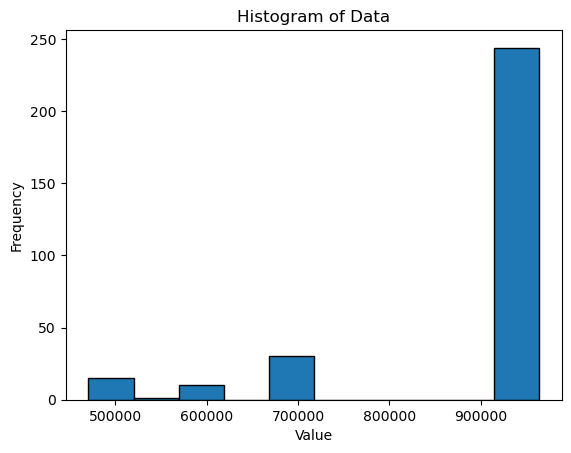

In [77]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.hist(history, bins=10, edgecolor='black')

# Adding labels and title
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display the plot
plt.show()

So, for the chosen value of gamma, the best partition is...

In [78]:
# Visualize
best_partition

6

Compute stratified metrics with unbiased testset.

In [79]:
for gamma in GAMMAS:
    key = "STRATIFIED_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=4, partition=best_partition)
    biased_results[key] = stratified(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=20, partition=best_partition)

This version uses the linspace of items instead of linspace of propensities to make the partition.

In [80]:
for gamma in GAMMAS:
    key = "STRATIFIED_v2_" + str(gamma).replace(".","")
    unbiased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-unbiased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-unbiased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=4, partition=best_partition)
    biased_results[key] = stratified_2(OUTPUT_PREFIX+"-test-pos-biased_evaluate_partial.pickle", OUTPUT_PREFIX+"-test-neg-biased_evaluate_partial.pickle", output_name+"training_arr.npy", propensities[gamma], K=20, partition=best_partition)


In [81]:
rows = 0
columns = len(biased_results.keys())

for key in biased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

for key in unbiased_results.keys():
    rows = max(rows, len(biased_results[key].keys()))

rows, columns

(4, 13)

In [82]:
# Init dictionary
mae_results = dict()

# Get the names of the rows
list_biased_res = list(biased_results.keys())

# Init results
results_array = np.zeros((rows,columns))

Fill the table with the MAE results.

In [83]:
# For each row
for i in range(len(list_biased_res)):
    key = list_biased_res[i]

    # For each column
    for j in range(len(list(biased_results[key].keys()))):
        key_2 = list(biased_results[key].keys())[j]

        # Compute MAE
        results_array[j][i] = abs(biased_results[key][key_2] - unbiased_results[key][key_2])

# Make it a DataFrame
mae_df = pd.DataFrame(columns=list(biased_results.keys()), data=results_array)
metric_values = list(biased_results[list(biased_results.keys())[0]].keys())
mae_df.insert(0, "metric", metric_values)

# **RESULTS**

In [84]:
print("Minimization was done for gamma = ", optimized_gamma, ". The best number of partitions: ", best_partition)

Minimization was done for gamma =  1.5 . The best number of partitions:  6


In [85]:
# Visualize
mae_df.head()

,metric,AOA,UB_15,UB_2,UB_25,UB_3,STRATIFIED_15,STRATIFIED_2,STRATIFIED_25,STRATIFIED_3,STRATIFIED_v2_15,STRATIFIED_v2_2,STRATIFIED_v2_25,STRATIFIED_v2_3
0,auc,0.053059,0.079417,0.082758,0.085431,0.087549,0.178458,0.232100,0.900003,1.257112,0.144429,0.170972,0.202982,0.242326
1,recall,0.079743,0.101476,0.103812,0.105615,0.106997,0.193324,0.261554,0.863686,1.343783,0.171052,0.197645,0.229911,0.269758
2,bias,0.000000,0.000000,0.000000,0.000000,0.000000,14169.780763,27403.632620,53687.071487,95770.937594,768.757652,949.728330,1146.249376,1359.297325
3,concentration,0.000000,0.000000,0.000000,0.000000,0.000000,23628.903555,58226.462039,133216.259962,308337.847416,57909.105024,151430.920236,388502.663031,982776.161464
